<a href="https://colab.research.google.com/github/OliverEvans96/planck-integral/blob/main/NumericalBenchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpmath import mp # high-precision math
import matplotlib.pyplot as plt # plotting
import sympy as sp # symbolic math
from tqdm.notebook import tqdm # progress bars

In [2]:
# Use high-precision constants
mp_k = mp.mpf("1.380649e-23")
mp_h = mp.mpf("6.62607015e-34")
mp_c = mp.mpf("299792458")

In [3]:
# Download data file from github
!mkdir -p data
!wget -O data/phos.dat https://raw.githubusercontent.com/OliverEvans96/planck-integral/refs/heads/main/data/phos.dat

--2024-12-02 00:43:41--  https://raw.githubusercontent.com/OliverEvans96/planck-integral/refs/heads/main/data/phos.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216086 (211K) [text/plain]
Saving to: ‘data/phos.dat’

data/phos.dat       100%[===================>] 211.02K  --.-KB/s    in 0.03s   

2024-12-02 00:43:41 (7.57 MB/s) - ‘data/phos.dat’ saved [216086/216086]



In [4]:
def plancks_law(nu, T):
  return 2 * mp_h * nu**3 / ((mp.exp(mp_h * nu / (mp_k * T)) - 1) * mp_c**2 )

In [5]:
def integrate_planck_dist(T, nu_max):
  """Integrate the Planck distribution for the given `T` (K) from 0 to `nu_max`"""
  return mp.quad(lambda nu: plancks_law(nu, T), [0, nu_max])

In [6]:
def calc_planck_integrals(T, freqs):
  """Calculate the integral of a single Planck distribution from 0 to multiple frequency values (Hz)"""
  integrals = []
  for freq in tqdm(freqs):
    integral = integrate_planck_dist(T, freq)
    integrals.append(integral)
  return integrals

# Test `mpmath` precision

In [7]:
def test_mpmath_precision(nu, T):
  digits_range = list(range(1, 100))
  integral_vals = []
  for num_digits in digits_range:
    with mp.workdps(num_digits):
      integral = integrate_planck_dist(T, nu)
    integral_vals.append(integral)

  final_ans = integral_vals[-1]
  err_arr = []
  for ans in integral_vals[:-1]:
    err = abs(ans - final_ans)
    err_arr.append(err)

  plt.plot(digits_range[:-1], err_arr)
  plt.yscale('log')
  plt.xlabel('requested precision (decimal digits)')
  plt.ylabel('error')
  plt.grid('on')
  plt.show()

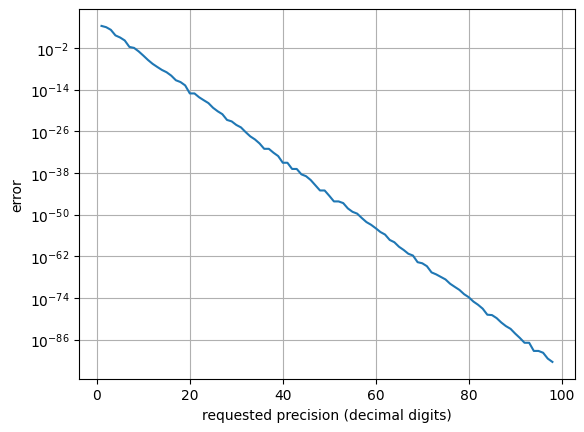

In [8]:
test_mpmath_precision(
  nu = 877253052027857.375, # Hz
  T = 6007, # K
)

Calculating the same integral using `mpmath` with a variety of precisions and comparing to the highest precision result, we see the error decrease linearly, as expected. The small flat patches are due to the discrepancy between binary and decimal precision. See [the docs](https://mpmath.org/doc/current/basics.html) for more details.

# Calculate peak frequency

We calculate the derivative of the Planck distribution function and find its nonzero root.

In [9]:
sp_h, sp_k, sp_c, sp_nu, sp_T = sp.var('h, k, c, nu, T')

In [10]:
def plancks_law_sym(nu, T):
  return 2 * sp_h * nu**3 / ((sp.exp(sp_h * nu / (sp_k * T)) - 1) * sp_c**2 )

In [11]:
crit_eq = sp.Eq(sp.diff(plancks_law_sym(sp_nu, sp_T), sp_nu), 0)
crit_eq

Eq(6*h*nu**2/(c**2*(exp(h*nu/(T*k)) - 1)) - 2*h**2*nu**3*exp(h*nu/(T*k))/(T*c**2*k*(exp(h*nu/(T*k)) - 1)**2), 0)

We can simplify using the substitution $x = \frac{h \nu}{T k}$.

In [12]:
sp_x = sp.var('x')

In [13]:
crit_eq_x = crit_eq.subs(sp_h*sp_nu/(sp_T*sp_k), sp_x)
crit_eq_x

Eq(-2*h*nu**2*x*exp(x)/(c**2*(exp(x) - 1)**2) + 6*h*nu**2/(c**2*(exp(x) - 1)), 0)

In [14]:
sp.simplify(crit_eq_x)

Eq(2*h*nu**2*(-x*exp(x) + 3*exp(x) - 3)/(c**2*(1 - exp(x))**2), 0)

The above critical equation is satisfied when $-xe^x + 3e^x - 3 = 0$.

This is a transcendental equation which must be solved numerically. The solution is roughly $x^*=2.821$.

Then we substitute $x$ back to its original value to find the peak frequency,

$\nu^* = \frac{kT}{h} x^*$.

In [15]:
def peak_eq(x):
  return -x * mp.exp(x) + 3 * mp.exp(x) - 3

In [16]:
def calc_peak_freq(T):
  x_val = mp.findroot(peak_eq, 2.8)
  nu_peak = x_val * mp_k * T / mp_h
  return nu_peak

# I/O Functions

In [17]:
def read_data_file(data_path):
  freqs = []
  with open(data_path) as data_file:
    for line in data_file.readlines():
      # strip whitespace
      stripped = line.strip()
      # skip blank lines
      if len(stripped) == 0:
        continue
      # Get frequency from second column
      freq = mp.mpf(line.split()[1])
      freqs.append(freq)
  return freqs

In [18]:
def format_float(val, num_digits):
  """Print a high-precision float with the given number of digits"""
  # set min_fixed and max_fixed to avoid exponential notation
  return mp.nstr(
      val,
      n=num_digits,
      strip_zeros=False,
      min_fixed=-mp.inf,
      max_fixed=mp.inf,
    )

In [19]:
def write_output(filename, freqs, integrals, num_digits):
  with open(filename, 'w', encoding='utf8') as out_file:
    for freq, integral in zip(freqs, integrals):
      freq_formatted = format_float(freq, 25)
      integral_formatted = format_float(integral, num_digits)

      out_file.write(freq_formatted)
      out_file.write(' ')
      out_file.write(integral_formatted)
      out_file.write(' ')
      out_file.write("[ W/m² ] / [ Sr ]")
      out_file.write('\n')

In [20]:
def plot_planck_dist(T):
  nu_arr = list(range(1, int(1e15), int(1e12))) # Hz
  B_arr = [plancks_law(nu, T) for nu in nu_arr]
  B_max = max(B_arr)
  nu_peak = float(calc_peak_freq(T))

  plt.plot(nu_arr, B_arr, label=f'Planck(Hz, {T} K)')
  plt.xlabel(r'$\nu$')
  plt.ylabel(r'$B_\nu$')
  plt.vlines([nu_peak], 0, B_max, color='C1', ls='--', label=f'Peak ({nu_peak:.3e} Hz)')
  plt.legend()
  plt.show()

# Run the calculations

In [21]:
def produce_benchmarks(data_path, T, workdps=50, outdps=25):
  """Perform all of the above calculations for the given `T` (Hz).

  Read the input file from `data_path`, calculate the integrals, and write the output file.

  The `workdps` parameter specifies the number of decimal digits used by `mpmath`
  for all calculations.

  The `outdps` parameter specifies the number of digits written to the output files.
  """
  with mp.workdps(workdps):
    plot_planck_dist(T)
    freqs = read_data_file(data_path)
    nu_peak = calc_peak_freq(T)
    # Prepend peak frequency to frequency list
    freqs.insert(0, nu_peak)
    integrals = calc_planck_integrals(T, freqs)
    filename = 'planck_integrals_{}K.dat'.format(T)
    write_output(filename, freqs, integrals, num_digits=25)


In [22]:
data_path = './data/phos.dat'

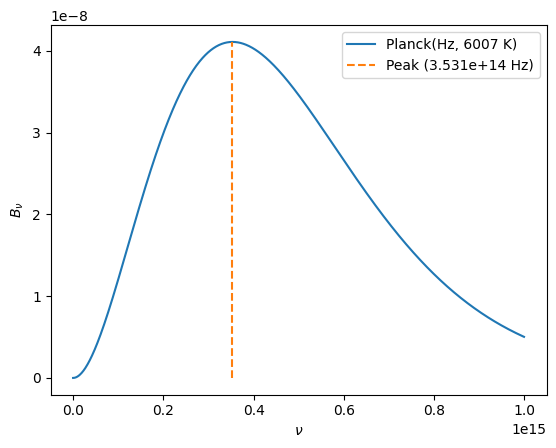

  0%|          | 0/2048 [00:00<?, ?it/s]

In [23]:
produce_benchmarks(data_path, T=6007)

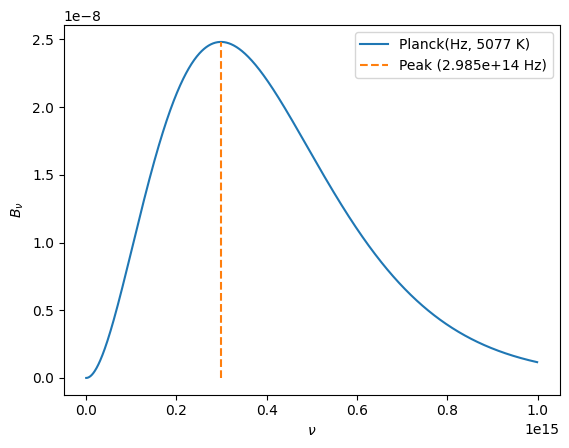

  0%|          | 0/2048 [00:00<?, ?it/s]

In [24]:
produce_benchmarks(data_path, T=5077)